In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import gridspec
from matplotlib.transforms import blended_transform_factory
from itertools import product
import pandas as pd
import seaborn as sns

from pypet.trajectory import Trajectory
import collective_behavior_analysis as cba


def load_result(filename, vis_input_method):
    traj = Trajectory(filename=filename)

    # Now we want to load all stored data.
    traj.f_load(index=-1, load_parameters=2, load_results=1)
    traj.v_auto_load = True

    par_names = ['speed0', 'noisep', 'seed']
    filter_params = ['vis_input_method']
    filter_func = lambda vis_method: vis_method == vis_input_method

    result_specs = {'names': ['startle_freq'],
                    'funcs': [cba.calcStartlingFrequencyWithBurning],
                    'input_variables': [['results.outdata.crun.startle', 'par.total_time',
                                         'par.output']]}
    time_result_specs = {'names': ['pol', 'coh'],
                         'funcs': [cba.calcPolarization, cba.get_calcCohesion('nearest')],
                         'input_variables': [['results.outdata.crun.uw'],
                                             ['results.outdata.crun.pos']]}

    res, time_res, ranges, unique_vals, lengths = cba.collect_filtered_results(traj, par_names,
                                                                               result_specs,
                                                                               time_result_specs,
                                                                               filter_params,
                                                                               filter_func)
    return res, time_res, ranges, unique_vals, lengths


filename = os.path.join(os.path.expanduser('/extra/swarmstartle_results'),
                        'looming_swarm_fitted_model_fixed_rho_null_kmd_matrix.hdf5')

In [2]:
def CalcDistVecMatrix(pos, L, BC):
    """ Calculate N^2 distance matrix (d_ij)

        Returns:
        --------
        distmatrix - matrix of all pairwise distances (NxN)
        dX - matrix of all differences in x coordinate (NxN)
        dY - matrix of all differences in y coordinate (NxN)
    """
    X = np.reshape(pos[:, 0], (-1, 1))
    Y = np.reshape(pos[:, 1], (-1, 1))
    dX = np.subtract(X, X.T)
    dY = np.subtract(Y, Y.T)
    dX_period = np.copy(dX)
    dY_period = np.copy(dY)
    if BC == 0:
        dX_period[dX > +0.5 * L] -= L
        dY_period[dY > +0.5 * L] -= L
        dX_period[dX < -0.5 * L] += L
        dY_period[dY < -0.5 * L] += L
    distmatrix = np.sqrt(dX_period ** 2 + dY_period ** 2)
    return distmatrix, dX_period, dY_period


def PeriodicDist(x, y, L=10.0, dim=2):
    """ Returns the distance vector of two position vectors x,y
        by tanking periodic boundary conditions into account.

        Input parameters: L - system size, dim - number of dimensions
    """
    distvec = (y - x)
    distvec_periodic = np.copy(distvec)
    distvec_periodic[distvec < -0.5 * L] += L
    distvec_periodic[distvec > 0.5 * L] -= L

    return distvec_periodic


def calc_periodic_mass_center(pos, arena_size):
    periodic_center = np.zeros(2)
    norm_term = 2*np.pi/arena_size
    for dim_idx in range(2):
        circ_coords = np.zeros((pos.shape[0], 2))
        circ_coords[:, 0] = np.cos((pos[:, dim_idx] * norm_term)) / norm_term
        circ_coords[:, 1] = np.sin((pos[:, dim_idx] * norm_term)) / norm_term
        mean_circ_coords = np.mean(circ_coords, axis=0)
        mean_angle = np.arctan2(-mean_circ_coords[1], -mean_circ_coords[0]) + np.pi
        periodic_center[dim_idx] = mean_angle/norm_term
    return periodic_center


def calcStartlePosition(pos, startles, L, output_step, burn_period = 50, cohesion_measures=None):
    burn_period_steps = int(burn_period/output_step)
    ntimesteps = pos.shape[0]
    startle_dists = np.array([])
    startle_distvecs = None
    for t in np.arange(burn_period_steps, ntimesteps):
        startle_idc = np.where(startles[t, :])[0]
        if startle_idc.size == 0:
            continue
        else:
            cmass_center = calc_periodic_mass_center(pos[t, :, :], L)
            center_distvecs = PeriodicDist(cmass_center, pos[t, :, :], L)
            if cohesion_measures is not None:
                center_distvecs = center_distvecs/cohesion_measures[t]
                
            center_dists = np.sqrt(center_distvecs[:, 0] ** 2 + center_distvecs[:, 1] ** 2)

            startle_dists = np.concatenate((startle_dists, center_dists[startle_idc]))
            if startle_distvecs is None:
                startle_distvecs = center_distvecs[startle_idc]
            else:
                startle_distvecs = np.concatenate((startle_distvecs, center_distvecs[startle_idc]))
    return startle_dists, startle_distvecs


def calcPolarization(direction_vecs):
    """
    Calculates the group polarization.

    We use the definition by Couzin et. al 2002 here:
    p_group(t) = 1/N * |sum from {i=1} to {N} (v_i(t)|

    where N is the number of agents and v_i is a unit direction vector.

    :param outData:
        The simulation output as defined in SwarmStartle.
    :return:
    """
    mean_ux = np.mean(direction_vecs[:, :, 0], axis=1)
    mean_uy = np.mean(direction_vecs[:, :, 1], axis=1)
    return np.sqrt(mean_ux**2 + mean_uy**2)

def calcCohesion(pos, L, BC, method='nearest'):
    from scipy.spatial import ConvexHull
    ntimesteps = pos.shape[0]
    coh = np.empty(ntimesteps)
    for t in np.arange(ntimesteps):
        if method == 'nearest':
            dist_mat, dx, dy = CalcDistVecMatrix(pos[t, :, :], L, BC)
            np.fill_diagonal(dist_mat, np.inf)
            min_dists = np.min(dist_mat, axis=0)
            current_cohesion = np.mean(min_dists)
        elif method == 'convexhull':
            hull = ConvexHull(pos[t, :, :])
            # volume is referring to a 3D setting so in a 2D case it gives the area
            current_cohesion = hull.volume
        elif method == 'convexhull_periodic':
            cmass_center = calc_periodic_mass_center(pos[t, :, :], L)
            center_distvecs = PeriodicDist(cmass_center, pos[t, :, :], L)
            hull = ConvexHull(center_distvecs)
            # volume is referring to a 3D setting so in a 2D case it gives the area
            current_cohesion = hull.volume
        elif method == 'inter':
            dist_mat, dx, dy = CalcDistVecMatrix(pos[t, :, :], L, BC)
            np.fill_diagonal(dist_mat, np.nan)
            mean_dists = np.nanmean(dist_mat, axis=0)
            current_cohesion = np.mean(mean_dists)
        else:
            current_cohesion = 0
        coh[t] = current_cohesion
    return coh

def calcCascadeSizes(startles, output_step, burn_period=50, time_margin=0.2):
    """Calculates the sizes of startle cascades.

    Parameters
    ----------
    startles
        An array with booleans for each agent and time point.

    Returns
    -------

    """
    burn_period_steps = int(burn_period/output_step)
    time_margin_steps = int(time_margin/output_step)
    ntimesteps = startles.shape[0]
    ncascades = 0
    cascade_sizes = []
    cascade_lengths = []
    single_startle = False
    ongoing_cascade = False
    current_cascade_members = []
    previous_startle_idc = []
    last_startle_time_idx = 0
    current_cascade_length = 0
    starting_points = []
    for t in np.arange(burn_period_steps , ntimesteps):
        startle_idc = np.where(startles[t, :])[0]
        time_since_last_startle = t - last_startle_time_idx
        # no startles at current time step:
        if startle_idc.size == 0:
            if ongoing_cascade and time_since_last_startle > time_margin_steps:
                cascade_sizes.append(len(current_cascade_members))
                cascade_lengths.append(current_cascade_length)
                ncascades += 1
                ongoing_cascade = False
                current_cascade_members = []
                current_cascade_length = 0
            else:
                if single_startle and time_since_last_startle > time_margin_steps:
                    single_startle = False
                    current_cascade_members = []
                    current_cascade_length = 0
        # at least one fish startled:
        else:
            if ongoing_cascade:
                new_members = []
                for startle_idx in startle_idc:
                    if startle_idx not in previous_startle_idc:
                        new_members.append(startle_idx)
                if not len(new_members) == 0:
                    current_cascade_members.extend(new_members)
                current_cascade_length += 1
            else:
                if single_startle:
                    new_members = []
                    for startle_idx in startle_idc:
                        if startle_idx not in previous_startle_idc:
                            new_members.append(startle_idx)
                    if not len(new_members) == 0:
                        single_startle = False
                        ongoing_cascade = True
                        starting_points.append(t-1)
                        current_cascade_members.extend(new_members)
                    current_cascade_length += 1
                else:
                    single_startle = True
                    current_cascade_members.extend(startle_idc)
                    current_cascade_length += 1
            last_startle_time_idx = t
            previous_startle_idc = startle_idc
    return np.array(cascade_sizes), np.array(cascade_lengths), np.array(starting_points)

In [3]:
traj = Trajectory(filename=filename)

# Now we want to load all stored data.
traj.f_load(index=-1, load_parameters=2, load_results=1)
traj.v_auto_load = True

filter_params = ['speed0', 'noisep']
def filter_func (speed0, noisep):
    return speed0 == 1.75 and noisep == 0.2

idx_iterator = traj.f_find_idx(filter_params, filter_func)

pos_data = []
uw_data = []
vis_method_data = []
startle_data = []
vm_data = []
visangle_data = []
# fill result arrays
for run_idx in idx_iterator:
    traj.v_idx = run_idx
    pos_data.append(traj.f_get('results.outdata.crun.pos', fast_access=True, auto_load=True))
    uw_data.append(traj.f_get('results.outdata.crun.uw', fast_access=True, auto_load=True))
    vis_method_data.append(traj.f_get('vis_input_method', fast_access=True, auto_load=True))
    startle_data.append(traj.f_get('results.outdata.crun.startle', fast_access=True, auto_load=True))
    vm_data.append(traj.f_get('results.outdata.crun.v_m', fast_access=True, auto_load=True))
    visangle_data.append(traj.f_get('results.outdata.crun.vis_angles', fast_access=True, auto_load=True))

In [4]:
len(uw_data)

10

In [5]:
np.linspace(0.5, 3.0, 5)

array([0.5  , 1.125, 1.75 , 2.375, 3.   ])

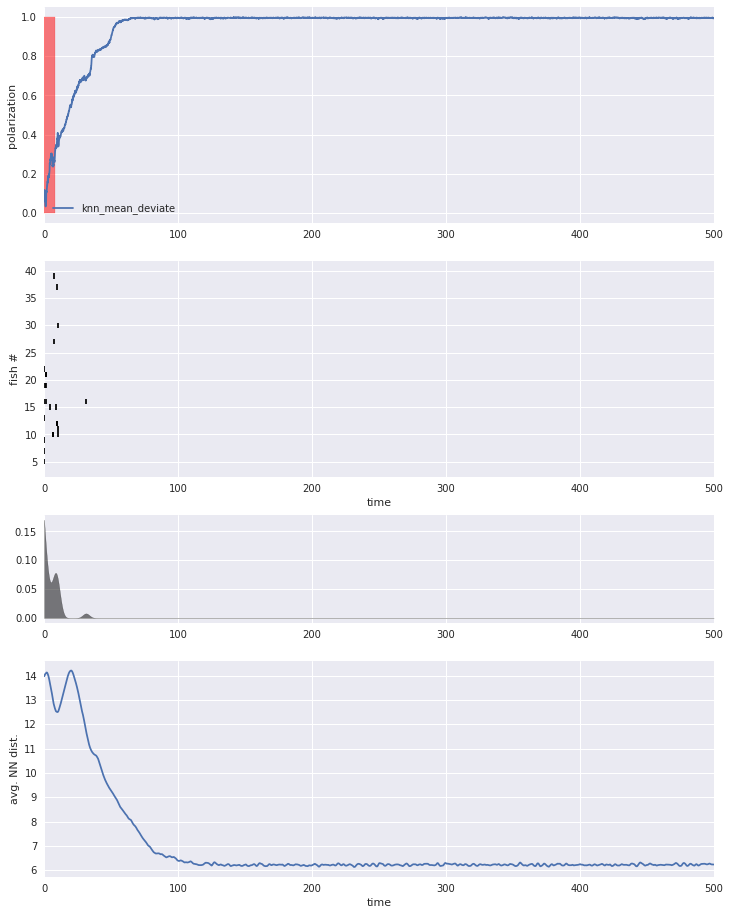

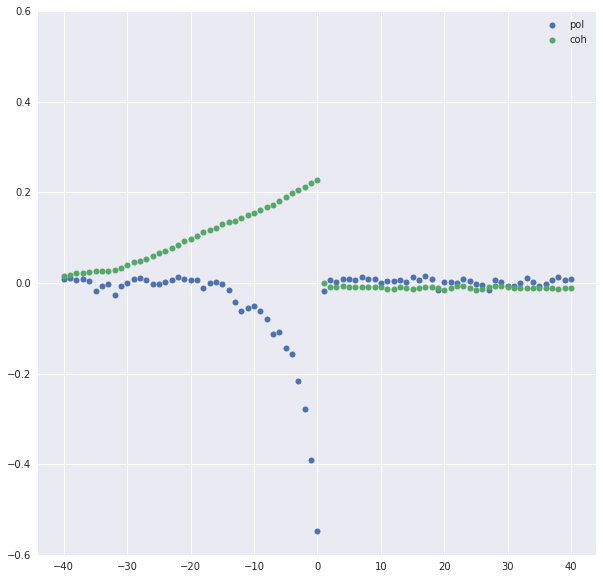

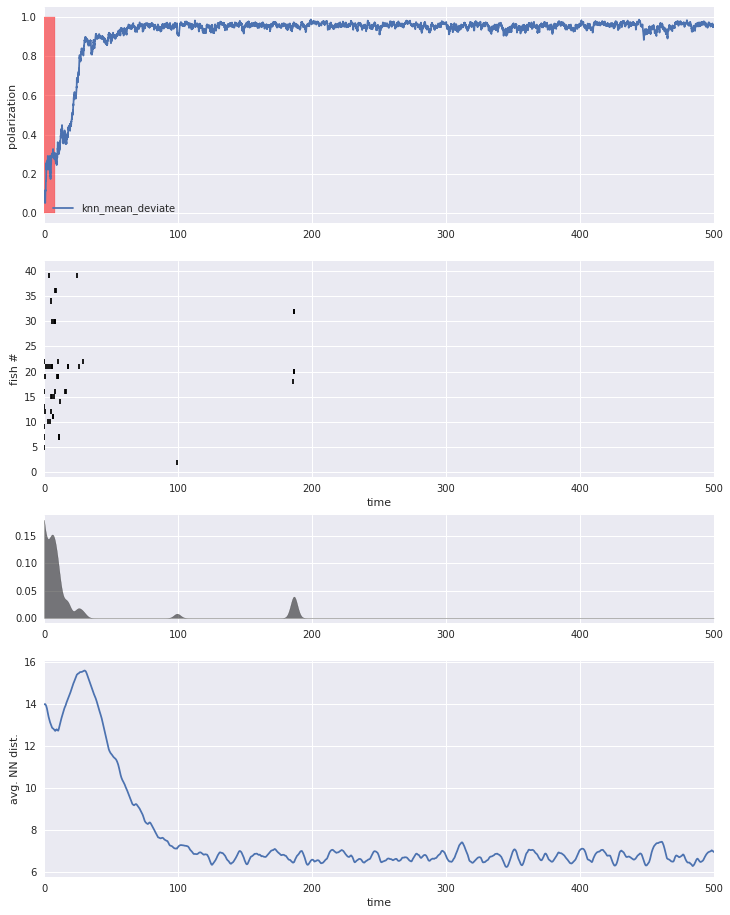

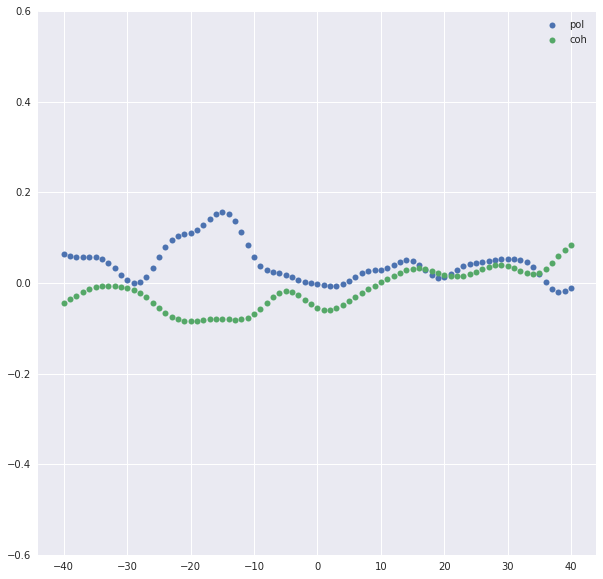

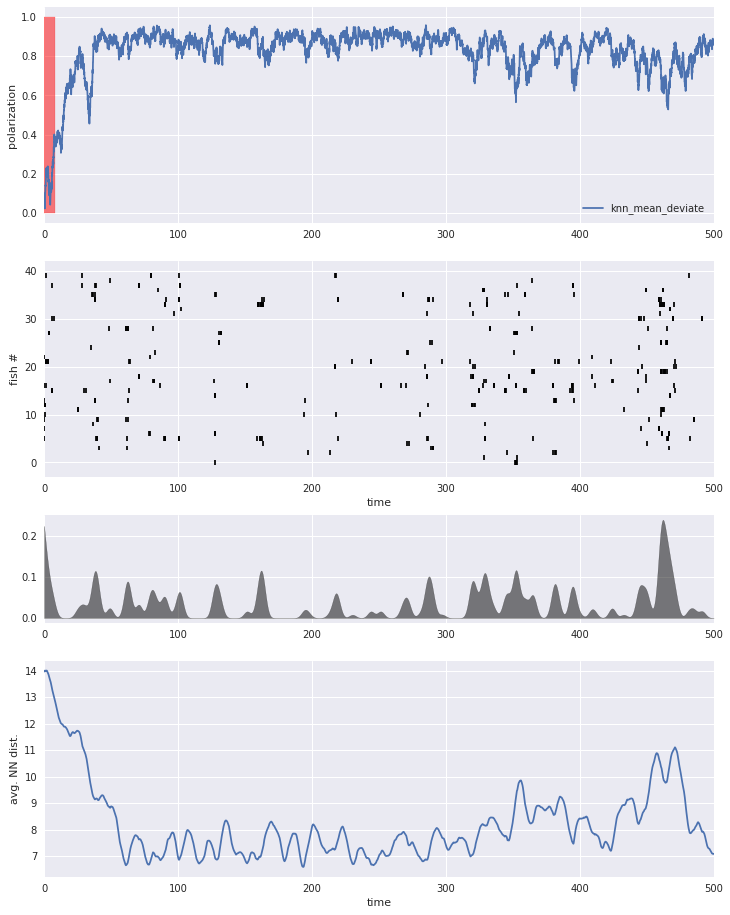

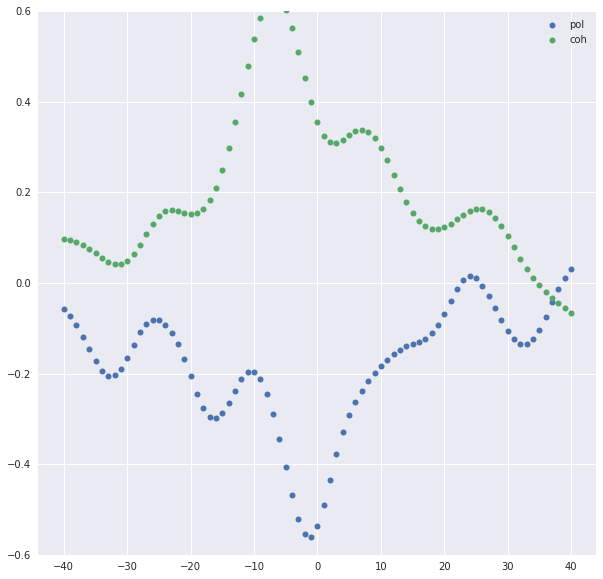

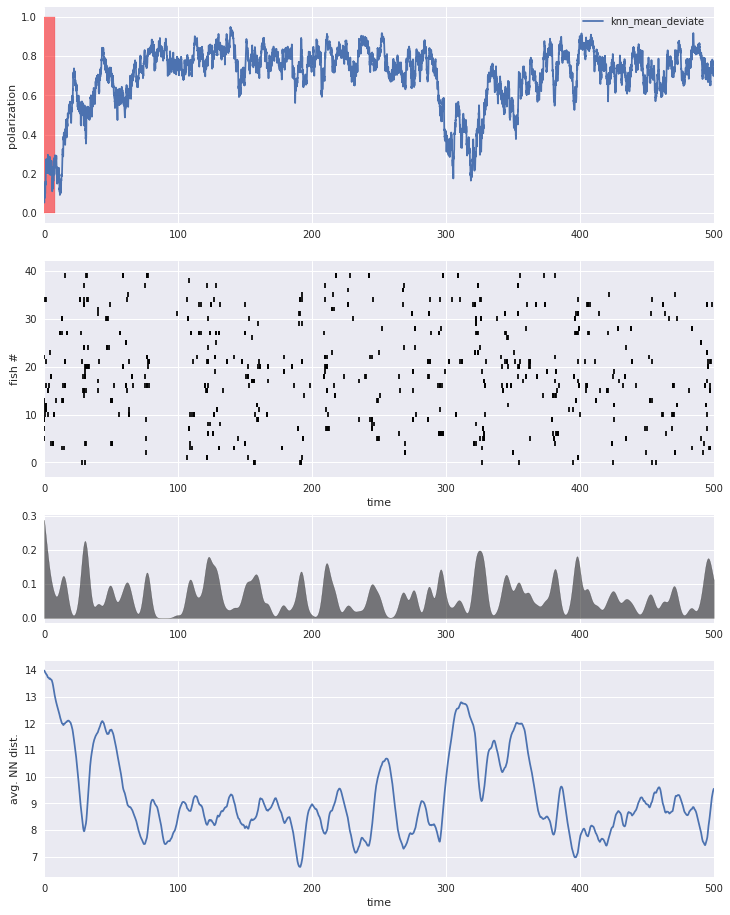

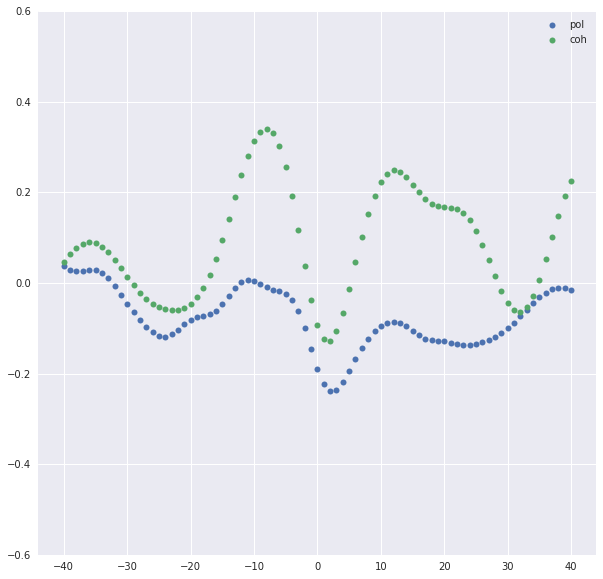

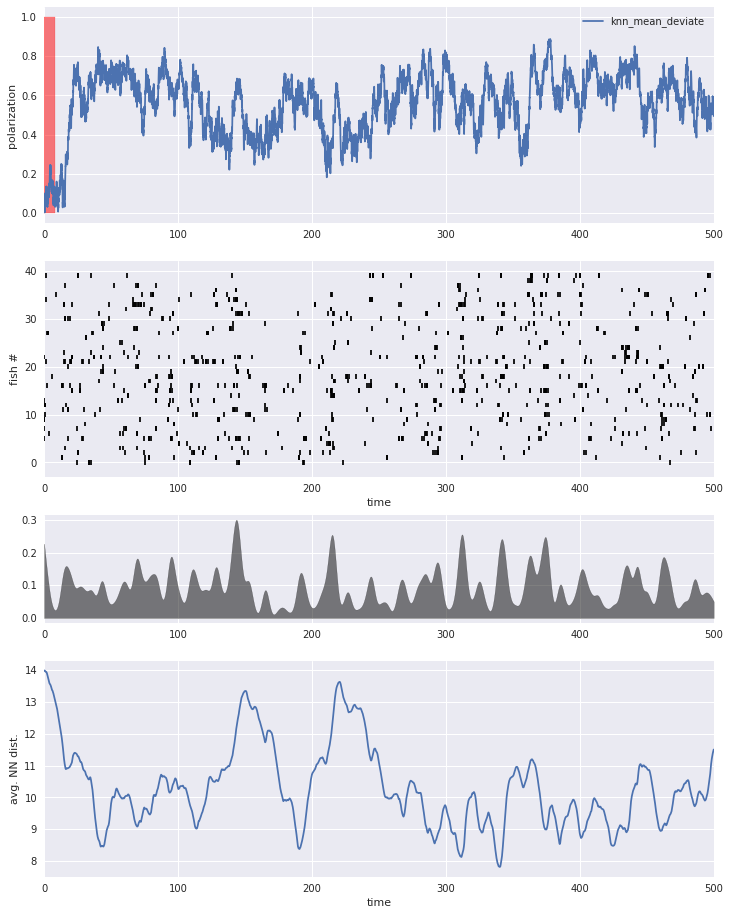

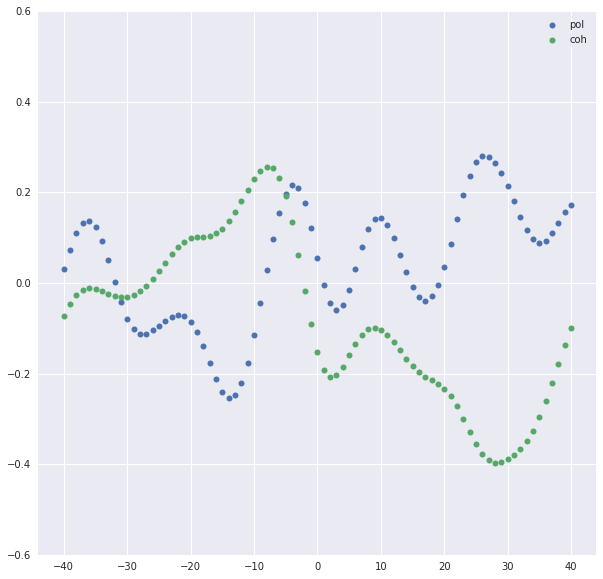

In [6]:
sns.set()
starttime = 0
endtime = 500
#for i in range(3):
i = 0
noise_vals = np.linspace(0.01, 0.2, 5)

for noise_idx, noise_val in enumerate(noise_vals):
    filter_params = ['speed0', 'noisep', 'int_type', 'vis_input_method']
    def filter_func (speed0, noisep, int_type, vis_method):
        return speed0 == 1.125 and noisep == noise_val and int_type == 'matrix' and vis_method == 'knn_mean_deviate'

    idx_iterator = traj.f_find_idx(filter_params, filter_func)

    pos_data = []
    uw_data = []
    vis_method_data = []
    startle_data = []
    vm_data = []
    visangle_data = []
    # fill result arrays
    for run_idx in idx_iterator:
        traj.v_idx = run_idx
        pos_data.append(traj.f_get('results.outdata.crun.pos', fast_access=True, auto_load=True))
        uw_data.append(traj.f_get('results.outdata.crun.uw', fast_access=True, auto_load=True))
        vis_method_data.append(traj.f_get('vis_input_method', fast_access=True, auto_load=True))
        startle_data.append(traj.f_get('results.outdata.crun.startle', fast_access=True, auto_load=True))
        vm_data.append(traj.f_get('results.outdata.crun.v_m', fast_access=True, auto_load=True))
        visangle_data.append(traj.f_get('results.outdata.crun.vis_angles', fast_access=True, auto_load=True))
    
    
    fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(12, 16), gridspec_kw={'height_ratios':[2, 2, 1, 2]})
    ax1 = axes[0]
    ax2 = axes[1]
    ax3 = axes[2]
    ax4 = axes[3]
    
    pol = calcPolarization(uw_data[i])

    ax1.plot(np.arange(len(pol))*traj.par.output, pol, label=vis_method_data[i])
    ax1.set_ylabel('polarization')
    ax1.fill_between([0, 8], [0, 0], [1, 1], color='r', alpha=0.5)
    ax1.set_xlim([starttime,endtime])
    #ax1.set_ylim([0.7, 1])


    startles = np.array(startle_data[i])
    startle_rows = [np.where(startles[:, row_idx]) for row_idx in range(startles.shape[1])]
    #a = a*traj.par.output
    for row_idx in range(startles.shape[1]):
        ax2.eventplot(np.array(startle_rows[row_idx])*traj.par.output, orientation='horizontal', color='k',
                      lineoffsets=row_idx)
    ax2.set_xlabel('time')
    ax2.set_ylabel('fish #')
    ax2.set_xlim([starttime,endtime])

    stlsum = np.sum(startles, axis=1)
    stlseries = pd.Series(stlsum)
    stlkde = stlseries.rolling(window=1000, win_type='gaussian', center=True, closed='both', min_periods=100)
    dat = stlkde.mean(std=50)
    ax3.fill_between(np.arange(len(stlseries))*traj.par.output, dat.fillna(0), color='k', alpha=0.5)
    ax3.set_xlim([starttime,endtime])

    coh = calcCohesion(np.array(pos_data[i]), L=traj.par.L, BC=traj.par.BC, method='inter')
    ax4.plot(np.arange(len(coh))*traj.par.output, coh)
    ax4.set_xlabel('time')
    ax4.set_ylabel('avg. NN dist.')
    ax4.set_xlim([starttime,endtime])
    ax1.legend()
    
    tstart_idx = int(50/traj.par.output)
    simdat = {'pol': pol[tstart_idx:], 'stlkde': dat[tstart_idx:], 'coh': coh[tstart_idx:]}
    simdf = pd.DataFrame(simdat)
    pol_ccoef_vals = []
    coh_ccoef_vals = []
    lags = np.arange(-800, 801, step=20)
    for lag in lags:
        shifted_pol = np.roll(simdf['pol'], shift=lag)
        shifted_coh = np.roll(simdf['coh'], shift=lag)
        pol_ccoef_vals.append(np.corrcoef(shifted_pol, simdf['stlkde'])[0, 1])
        coh_ccoef_vals.append(np.corrcoef(shifted_coh, simdf['stlkde'])[0, 1])
        
    plt.figure(figsize=(10, 10))
    plt.plot(lags*traj.par.output, pol_ccoef_vals, '.', ms=12, label='pol')
    plt.plot(lags*traj.par.output, coh_ccoef_vals, '.', ms=12, label='coh')
    plt.legend()
    plt.ylim([-0.6, 0.6])
    
plt.show()

In [7]:
noise_vals[[2,4]]

array([0.105, 0.2  ])

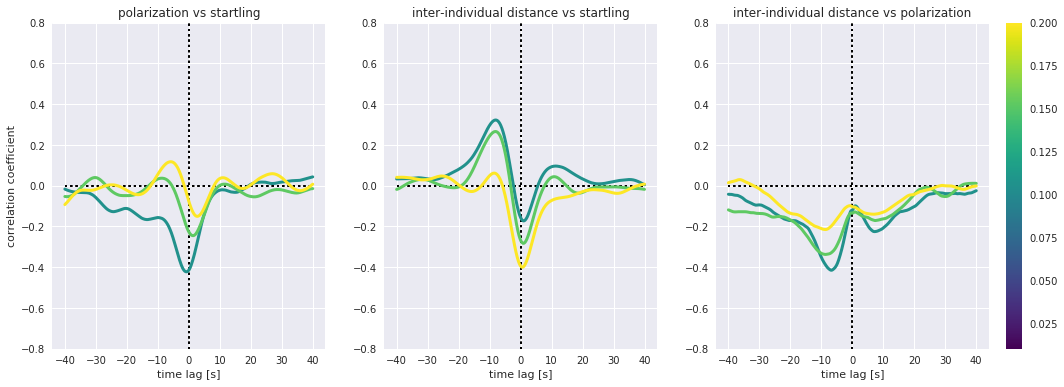

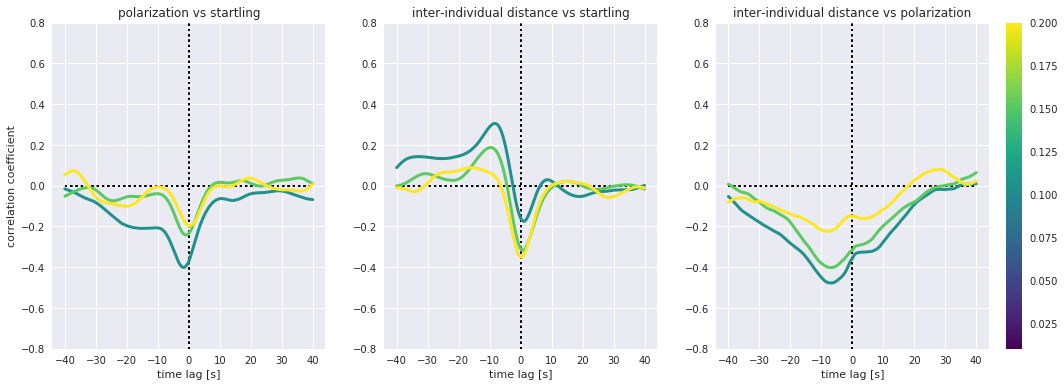

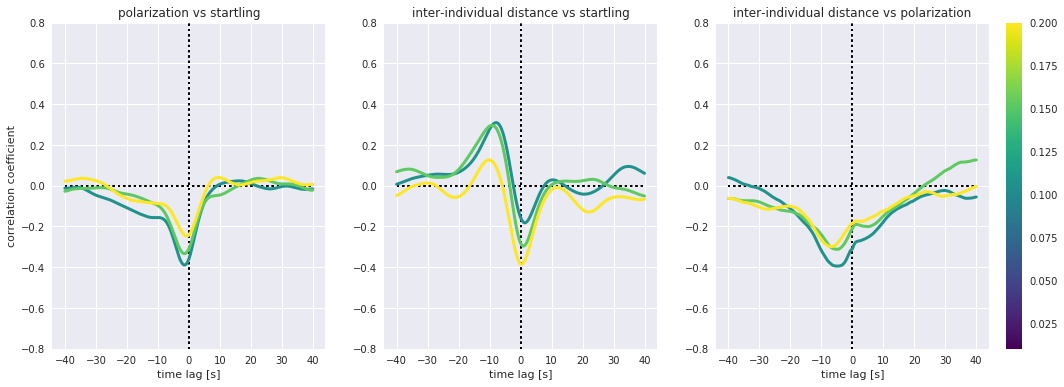

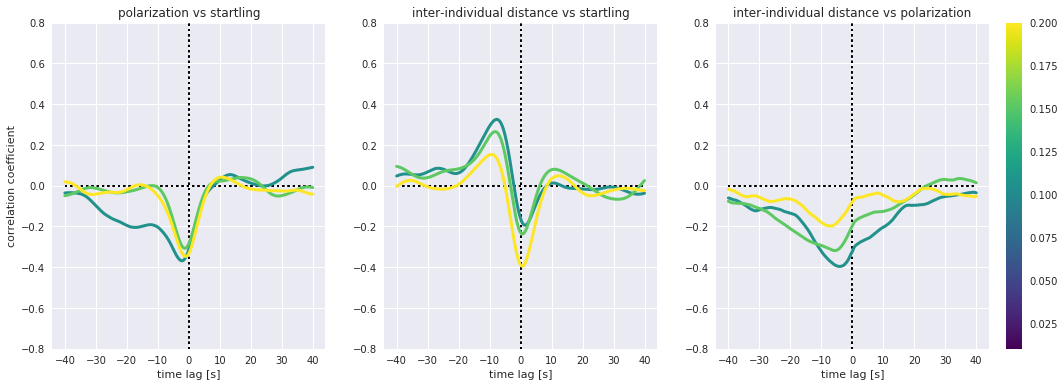

In [28]:
import matplotlib as mpl
noise_vals = np.linspace(0.01, 0.2, 5)
vmin = np.min(0.01)
vmax = np.max(0.2)
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax))

speed_vals = np.linspace(0.5, 3.0, 5)

for speed_val in speed_vals[1:]:
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6), gridspec_kw={'width_ratios':[4, 4, 5]})
    ax1 = axes[0]
    ax2 = axes[1]
    ax3 = axes[2]

    for noise_idx, noise_val in enumerate(noise_vals[2:]):
        filter_params = ['speed0', 'noisep', 'int_type', 'vis_input_method']
        def filter_func (speed0, noisep, int_type, vis_method):
            return speed0 == speed_val and noisep == noise_val and int_type == 'matrix' and vis_method == 'knn_mean_deviate'

        idx_iterator = traj.f_find_idx(filter_params, filter_func)

        pos_data = []
        uw_data = []
        vis_method_data = []
        startle_data = []
        vm_data = []
        visangle_data = []
        # fill result arrays
        for run_idx in idx_iterator:
            traj.v_idx = run_idx
            pos_data.append(traj.f_get('results.outdata.crun.pos', fast_access=True, auto_load=True))
            uw_data.append(traj.f_get('results.outdata.crun.uw', fast_access=True, auto_load=True))
            vis_method_data.append(traj.f_get('vis_input_method', fast_access=True, auto_load=True))
            startle_data.append(traj.f_get('results.outdata.crun.startle', fast_access=True, auto_load=True))
            vm_data.append(traj.f_get('results.outdata.crun.v_m', fast_access=True, auto_load=True))
            visangle_data.append(traj.f_get('results.outdata.crun.vis_angles', fast_access=True, auto_load=True))

        all_pol_coef = []
        all_coh_coef = []
        all_polcoh_coef = []
        for i in range(10):
            pol = calcPolarization(uw_data[i])

            coh = calcCohesion(np.array(pos_data[i]), L=traj.par.L, BC=traj.par.BC, method='nearest')

            startles = np.array(startle_data[i])
            stlsum = np.sum(startles, axis=1)
            stlseries = pd.Series(stlsum)
            stlkde = stlseries.rolling(window=1000, win_type='gaussian', center=True, closed='both', min_periods=100)
            dat = stlkde.mean(std=50)

            tstart_idx = int(50/traj.par.output)
            simdat = {'pol': pol[tstart_idx:], 'stlkde': dat[tstart_idx:], 'coh': coh[tstart_idx:]}
            simdf = pd.DataFrame(simdat)
            pol_ccoef_vals = []
            coh_ccoef_vals = []
            polcoh_ccoef_vals = []
            lags = np.arange(-800, 801, step=2)
            for lag in lags:
                shifted_pol = np.roll(simdf['pol'], shift=lag)
                shifted_coh = np.roll(simdf['coh'], shift=lag)
                pol_ccoef_vals.append(np.corrcoef(shifted_pol, simdf['stlkde'])[0, 1])
                coh_ccoef_vals.append(np.corrcoef(shifted_coh, simdf['stlkde'])[0, 1])
                polcoh_ccoef_vals.append(np.corrcoef(shifted_coh, simdf['pol'])[0, 1])

            all_pol_coef.append(np.array(pol_ccoef_vals)[:, np.newaxis])
            all_coh_coef.append(np.array(coh_ccoef_vals)[:, np.newaxis])
            all_polcoh_coef.append(np.array(polcoh_ccoef_vals)[:, np.newaxis])
            #plt.plot(lags*traj.par.output, pol_ccoef_vals, '-', lw=3, color=sm.to_rgba(noise_val), label='pol')
            #plt.plot(lags*traj.par.output, coh_ccoef_vals, '.', ms=8, color=sm.to_rgba(noise_val), label='coh')

        mean_pol_coef = np.mean(np.concatenate(all_pol_coef, axis=1), axis=1)
        ax1.plot(lags*traj.par.output, mean_pol_coef, '-', lw=3, color=sm.to_rgba(noise_val))
        ax1.set_xlabel('time lag [s]')
        ax1.set_ylabel('correlation coefficient')
        ax1.set_title('polarization vs startling')

        mean_coh_coef = np.mean(np.concatenate(all_coh_coef, axis=1), axis=1)
        ax2.plot(lags*traj.par.output, mean_coh_coef, '-', lw=3, color=sm.to_rgba(noise_val))
        ax2.set_title('inter-individual distance vs startling')
        ax2.set_xlabel('time lag [s]')

        mean_polcoh_coef = np.mean(np.concatenate(all_polcoh_coef, axis=1), axis=1)
        ax3.plot(lags*traj.par.output, mean_polcoh_coef, '-', lw=3, color=sm.to_rgba(noise_val))
        ax3.set_title('inter-individual distance vs polarization')
        ax3.set_xlabel('time lag [s]')

        for ax in axes:
            ax.hlines(0, -40, 40, color='k', linestyles=':', lw=2)
            ax.vlines(0, -0.8, 0.8, color='k', linestyles=':', lw=2)
            ax.legend()
            ax.set_ylim([-0.8, 0.8])
    sm.set_array([])
    plt.colorbar(sm, ax = plt.gca(), )

plt.show()

In [88]:
a = np.array([1,4,6])

b = np.arange(10)
mask = np.ones(len(b), dtype=np.bool)
mask[a] = 0
b[mask]

array([0, 2, 3, 5, 7, 8, 9])

In [92]:
# plot startle positions
def calcStartlePositionOriented(uw, pos, startles, L, output_step, burn_period = 50, cohesion_measures=None):
    burn_period_steps = int(burn_period/output_step)
    ntimesteps = pos.shape[0]
    all_dists = np.array([])
    all_distvecs = None
    startle_dists = np.array([])
    startle_distvecs = None
    for t in np.arange(burn_period_steps, ntimesteps):
        cmass_center = calc_periodic_mass_center(pos[t, :, :], L)
        center_distvecs = PeriodicDist(cmass_center, pos[t, :, :], L)
        if cohesion_measures is not None:
            center_distvecs = center_distvecs/cohesion_measures[t]
            
        mean_uw = np.mean(uw[t, :, :], axis=0)
        mean_uw_unit = mean_uw/np.linalg.norm(mean_uw)
        relative_ypos = center_distvecs[:, 0]*mean_uw_unit[0] + center_distvecs[:, 1]*mean_uw_unit[1]
        
        orth_mean_uw_unit = np.array([mean_uw_unit[1], - mean_uw_unit[0]])
        relative_xpos = center_distvecs[:, 0]*orth_mean_uw_unit[0] + center_distvecs[:, 1]*orth_mean_uw_unit[1]
        
        relative_pos = np.concatenate((relative_xpos[:, np.newaxis], relative_ypos[:, np.newaxis]), axis=1)

        center_dists = np.sqrt(center_distvecs[:, 0] ** 2 + center_distvecs[:, 1] ** 2)

            
        startle_idc = np.where(startles[t, :])[0]
        nonstartle_mask = np.ones(len(startles[t,:]), dtype=np.bool)
        nonstartle_mask[startle_idc] = 0
        if startle_idc.size == 0:
            continue
        else:
            startle_dists = np.concatenate((startle_dists, center_dists[startle_idc]))
            if startle_distvecs is None:
                startle_distvecs = relative_pos[startle_idc]
            else:
                startle_distvecs = np.concatenate((startle_distvecs, relative_pos[startle_idc]))
                
        all_dists = np.concatenate((all_dists, center_dists[nonstartle_mask]))
        if all_distvecs is None:
            all_distvecs = relative_pos[nonstartle_mask]
        else:
            all_distvecs = np.concatenate((all_distvecs, relative_pos[nonstartle_mask]))
    return all_dists, all_distvecs, startle_dists, startle_distvecs


def calcStartleAngle(uw, pos, startles, L, output_step, burn_period = 50):
    burn_period_steps = int(burn_period/output_step)
    ntimesteps = pos.shape[0]
    all_angles = np.array([])
    startle_angles = np.array([])
    for t in np.arange(burn_period_steps, ntimesteps):
        cmass_center = calc_periodic_mass_center(pos[t, :, :], L)
        center_distvecs = PeriodicDist(cmass_center, pos[t, :, :], L)

        mean_uw = np.mean(uw[t, :, :], axis=0)
        mean_uw_unit = mean_uw/np.linalg.norm(mean_uw)

        mean_uw_angle = np.arctan2(mean_uw_unit[1], mean_uw_unit[0]) + np.pi
        angles = mean_uw_angle - (np.arctan2(center_distvecs[:, 1], center_distvecs[:, 0]) + np.pi)
        
        
        startle_idc = np.where(startles[t, :])[0]
        nonstartle_mask = np.ones(len(startles[t,:]), dtype=np.bool)
        nonstartle_mask[startle_idc] = 0
        if startle_idc.size == 0:
            continue
        else:
            startle_angles = np.concatenate((startle_angles, angles[startle_idc]))
            
        all_angles = np.concatenate((all_angles, angles[nonstartle_mask]))
    return all_angles, startle_angles


def calcStartleOrientation(uw, pos, startles, L, output_step, burn_period = 50):
    burn_period_steps = int(burn_period/output_step)
    ntimesteps = pos.shape[0]
    all_orientations = np.array([])
    all_frontness = np.array([])
    startle_orientations = np.array([])
    startle_frontness = np.array([])
    for t in np.arange(burn_period_steps, ntimesteps):
        startle_idc = np.where(startles[t, :])[0]
        nonstartle_mask = np.ones(len(startles[t,:]), dtype=np.bool)
        nonstartle_mask[startle_idc] = 0
        if startle_idc.size == 0:
            continue
        else:
            cmass_center = calc_periodic_mass_center(pos[t, :, :], L)
            center_distvecs = PeriodicDist(cmass_center, pos[t, :, :], L)
            
            mean_uw = np.mean(uw[t, :, :], axis=0)
            mean_uw_unit = mean_uw/np.linalg.norm(mean_uw)
            frontness_vals = center_distvecs[:, 0]*mean_uw_unit[0] + center_distvecs[:, 1]*mean_uw_unit[1]
            orientations = uw[t, :, 0]*mean_uw_unit[0] + uw[t, :, 1]*mean_uw_unit[1]
            
            uw_angles = np.arctan2(uw[t, :, 1], uw[t, :, 0])
            mean_uw_angle = np.arctan2(mean_uw_unit[1], mean_uw_unit[0])
            orientation_angles = np.pi - np.abs(np.abs(uw_angles - mean_uw_angle) - np.pi)
            orientation_angles = orientation_angles/np.pi * 180
            
            all_orientations = np.concatenate((all_orientations, orientation_angles[nonstartle_mask]))
            all_frontness = np.concatenate((all_frontness, frontness_vals[nonstartle_mask]))
            
            startle_orientations = np.concatenate((startle_orientations, orientation_angles[startle_idc]))
            startle_frontness = np.concatenate((startle_frontness, frontness_vals[startle_idc]))
    return startle_orientations, startle_frontness, all_orientations, all_frontness


def get_startle_times(startles, output_step, burn_period=50):
    burn_period_steps = int(burn_period/output_step)
    ntimesteps = startles.shape[0]
    startle_times = np.array([])
    for t in np.arange(burn_period_steps, ntimesteps):
        startle_idc = np.where(startles[t, :])[0]
        nonstartle_mask = np.ones(len(startles[t,:]), dtype=np.bool)
        nonstartle_mask[startle_idc] = 0
        if startle_idc.size == 0:
            continue
        else:
            current_startle_times = np.ones(len(startle_idc))*(t/output_step)
            startle_times = np.concatenate((startle_times, current_startle_times))
    return startle_times


def plot_startle_pos(ax, traj, uw_data, pos_data, startle_data, burn_period, pool_data=True):
    if pool_data:
        all_startle_distvecs = []
        all_nonstartle_distvecs = []
        all_startle_orientations = []
        all_startle_times = []
        for data_idx in range(len(uw_data)):
            startle_pos_results = calcStartlePositionOriented(uw_data[data_idx],
                                                              pos_data[data_idx],
                                                              startle_data[data_idx],
                                                              traj.par.L,
                                                              traj.par.output,
                                                              burn_period,
                                                              None)
            all_dists, all_distvecs, startle_dists, startle_distvecs = startle_pos_results
            if not startle_distvecs is None:
                all_startle_distvecs.append(startle_distvecs)
                all_nonstartle_distvecs.append(all_distvecs)
            
            startle_orient_results = calcStartleOrientation(uw_data[data_idx],
                                                            pos_data[data_idx],
                                                            startle_data[data_idx],
                                                            traj.par.L,
                                                            traj.par.output,
                                                            burn_period)
            startle_orientations, startle_frontness, all_orientations, all_frontness = startle_orient_results
            if not len(startle_orientations) == 0:
                all_startle_orientations.append(startle_orientations)
                
            startle_times = get_startle_times(startle_data[data_idx], traj.par.output, burn_period)
            if not len(startle_times) == 0:
                all_startle_times.append(startle_times)
        
        all_startle_distvecs = np.concatenate(all_startle_distvecs)
        all_nonstartle_distvecs = np.concatenate(all_nonstartle_distvecs)
        all_startle_orientations = np.concatenate(all_startle_orientations)
        all_startle_times = np.concatenate(all_startle_times)
    
    if not startle_distvecs is None:
        #ax.plot(startle_distvecs[:, 0], startle_distvecs[:, 1], '.', alpha=0.5)
        sc = ax.scatter(all_startle_distvecs[:, 0], all_startle_distvecs[:, 1], marker='.', alpha=0.5, label='startle')
        sc = ax.scatter(all_nonstartle_distvecs[:, 0], all_nonstartle_distvecs[:, 1], marker='.', alpha=0.1, label='nonstartle')
        ax.hlines(0, -25, 25, color='k', linestyles=':', lw=2)
        ax.vlines(0, -25, 25, color='k', linestyles=':', lw=2)
        ax.set_xlim([-25, 25])
        ax.set_ylim([-25, 25])
        ax.set_title('number of startles: ' + str(len(all_startle_distvecs)))
        ax.legend()
        

def plot_startle_angle(ax, traj, uw_data, pos_data, startle_data, burn_period, pool_data=True):
    if pool_data:
        all_nonstartle_angles = []
        all_startle_angles = []
        for data_idx in range(len(uw_data)):
            all_angles, startle_angles = calcStartleAngle(uw_data[data_idx],
                                                          pos_data[data_idx],
                                                          startle_data[data_idx],
                                                          traj.par.L,
                                                          traj.par.output,
                                                          burn_period)
            if not len(startle_angles) == 0:
                all_startle_angles.append(startle_angles)
                all_nonstartle_angles.append(all_angles)
        
        all_startle_angles = np.concatenate(all_startle_angles)
        all_nonstartle_angles = np.concatenate(all_nonstartle_angles)
    
    hist, bin_edges = np.histogram(all_startle_angles, bins=50, density=True)
    nonstartle_hist, bin_edges = np.histogram(all_nonstartle_angles, bins=50, density=True)
    bin_width = bin_edges[1] - bin_edges[0]

    ax.set_theta_zero_location(loc='N')
    ax.set_theta_direction('clockwise')
    ax.bar(bin_edges[:-1], hist, width=bin_width, align='edge', label='startle', alpha=0.5)
    ax.bar(bin_edges[:-1], nonstartle_hist, width=bin_width, align='edge', label='nonstartle', alpha=0.5)
    
def plot_cascade_sizes(ax, traj, startle_data, burn_period, time_margin, pool_data=True):
    if pool_data:
        all_cascade_sizes = []
        all_cascade_lengths = []
        all_starting_points = []
        for startle_dat in startle_data:
            cascade_sizes, cascade_lengths, starting_points = calcCascadeSizes(startle_dat,
                                                                               traj.par.output,
                                                                               burn_period=burn_period,
                                                                               time_margin=time_margin)
            all_cascade_sizes.append(cascade_sizes)
            all_cascade_lengths.append(cascade_lengths)
            all_starting_points.append(starting_points)
        
        all_cascade_sizes = np.concatenate(all_cascade_sizes)
        all_cascade_lengths = np.concatenate(all_cascade_lengths)
        all_starting_points = np.concatenate(all_starting_points)
    ax.hist(all_cascade_sizes, bins=30, log=True)
    ax.set_title('number of cascadeds: ' + str(len(all_cascade_sizes)))
    
    
def plot_startle_dists(ax, traj, pos_data, startle_data, burn_period, pool_data=True):
    if pool_data:
        all_startle_dists = []
        all_nonstartle_dists = []
        for data_idx in range(len(pos_data)):
            startle_pos_results = calcStartlePositionOriented(uw_data[data_idx],
                                                              pos_data[data_idx],
                                                              startle_data[data_idx],
                                                              traj.par.L,
                                                              traj.par.output,
                                                              burn_period,
                                                              None)
            all_dists, all_distvecs, startle_dists, startle_distvecs = startle_pos_results
            if not startle_distvecs is None:
                all_startle_dists.append(startle_dists)
                all_nonstartle_dists.append(all_dists)
        
        all_startle_dists = np.concatenate(all_startle_dists)
        all_nonstartle_dists = np.concatenate(all_nonstartle_dists)

    ax.hist(all_nonstartle_dists, bins=30, density=True, label='nonstartle', alpha=0.5)
    ax.hist(all_startle_dists, bins=30, density=True, label='startle', alpha=0.5)

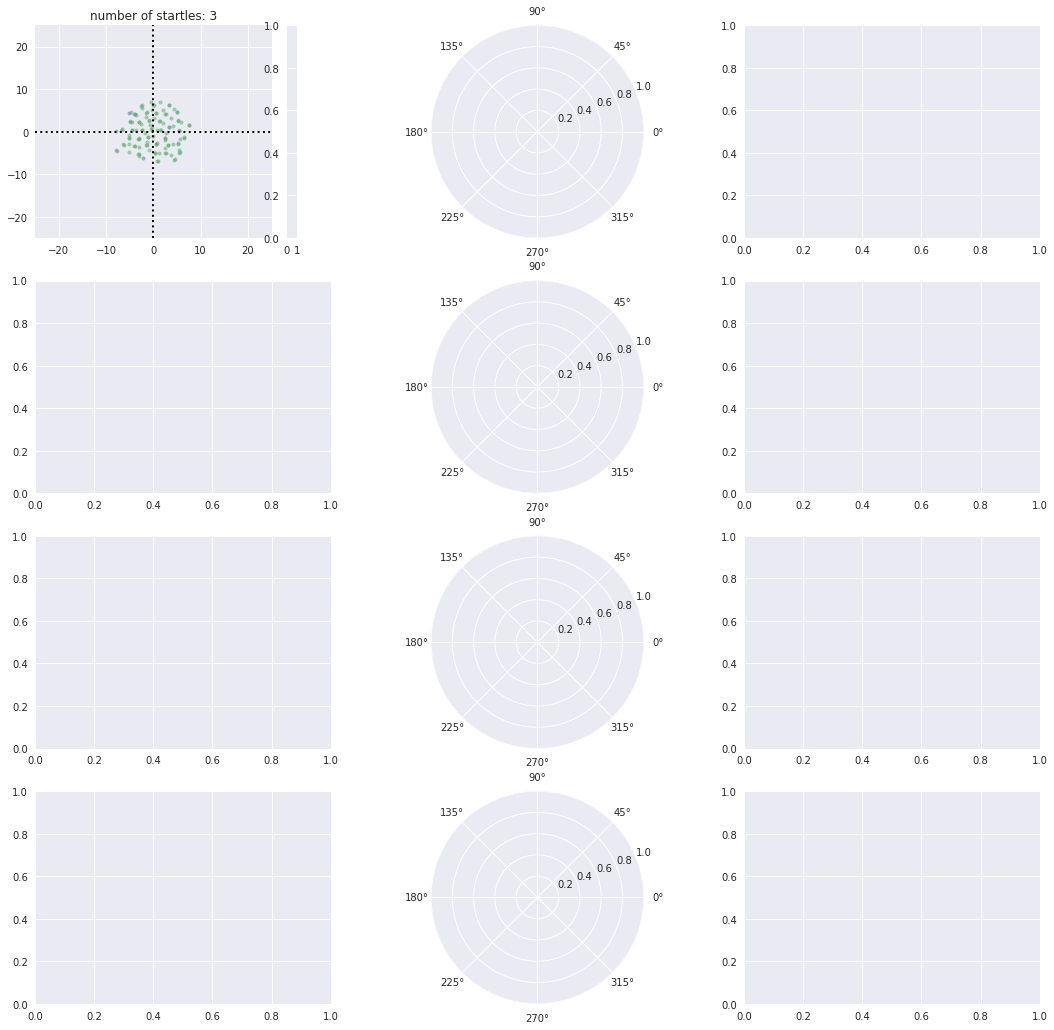

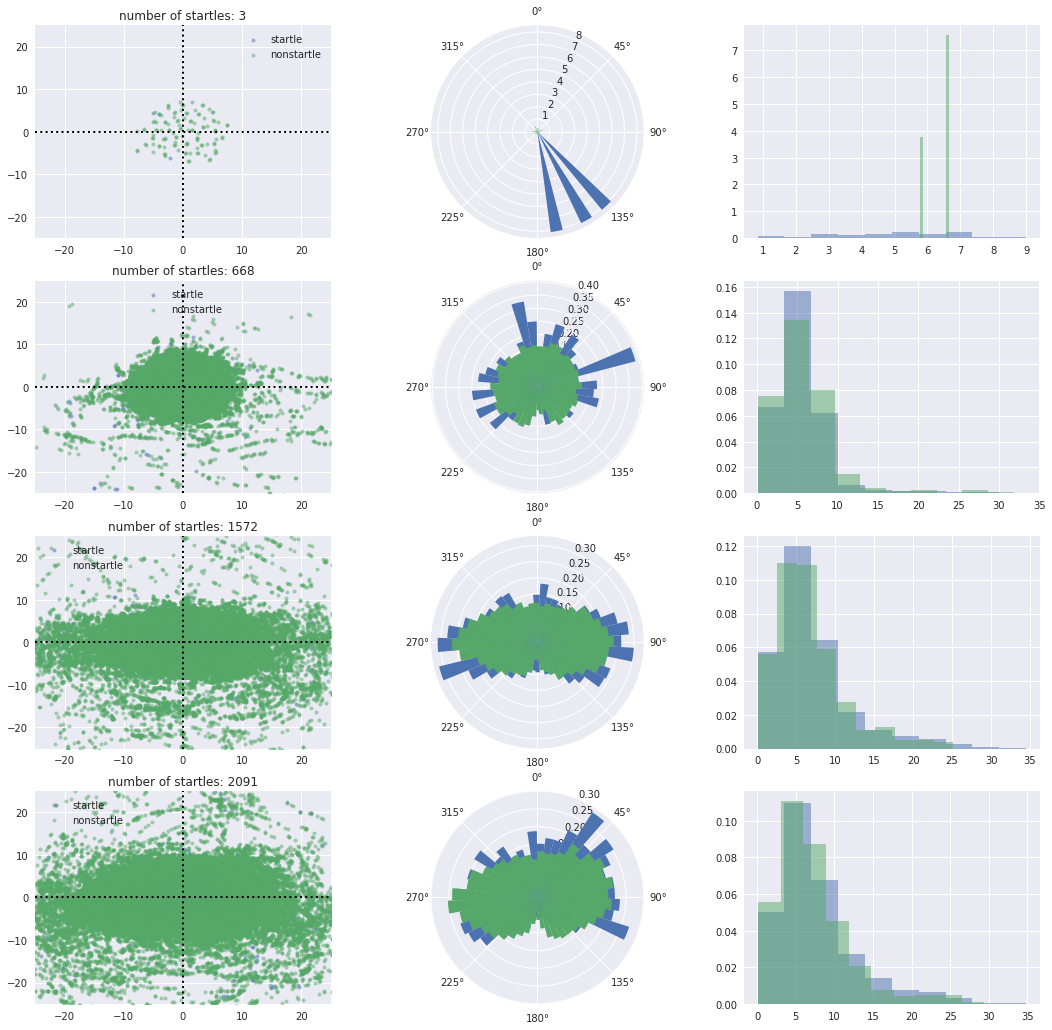

In [93]:
import matplotlib.gridspec as gridspec

seed_idx = 3

fig = plt.figure(figsize=(18, 18))
spec = gridspec.GridSpec(nrows=4, ncols=3)
basic_axes = [fig.add_subplot(spec[i, 0]) for i in range(4)]
polar_axes = [fig.add_subplot(spec[i, 1], projection='polar') for i in range(4)]
thirdcol_axes = [fig.add_subplot(spec[i, 2]) for i in range(4)]

for noise_idx, noise_val in enumerate(noise_vals[1:]):
    filter_params = ['speed0', 'noisep', 'int_type', 'vis_input_method']
    def filter_func (speed0, noisep, int_type, vis_method):
        return speed0 == speed_val and noisep == noise_val and int_type == 'matrix' and vis_method == 'knn_mean_deviate'

    idx_iterator = traj.f_find_idx(filter_params, filter_func)

    pos_data = []
    uw_data = []
    vis_method_data = []
    startle_data = []
    vm_data = []
    visangle_data = []
    # fill result arrays
    for run_idx in idx_iterator:
        traj.v_idx = run_idx
        pos_data.append(traj.f_get('results.outdata.crun.pos', fast_access=True, auto_load=True))
        uw_data.append(traj.f_get('results.outdata.crun.uw', fast_access=True, auto_load=True))
        startle_data.append(traj.f_get('results.outdata.crun.startle', fast_access=True, auto_load=True))

    plot_startle_pos(basic_axes[noise_idx], traj, uw_data[0:seed_idx], pos_data[0:seed_idx], startle_data[0:seed_idx], burn_period=100)
    plot_startle_angle(polar_axes[noise_idx], traj, uw_data[0:seed_idx], pos_data[0:seed_idx], startle_data[0:seed_idx], burn_period=100)
    #plot_cascade_sizes(thirdcol_axes[noise_idx], traj, startle_data, burn_period=100, time_margin=0.2)
    plot_startle_dists(thirdcol_axes[noise_idx], traj, pos_data[0:seed_idx], startle_data[0:seed_idx], burn_period=100)

    
plt.show()

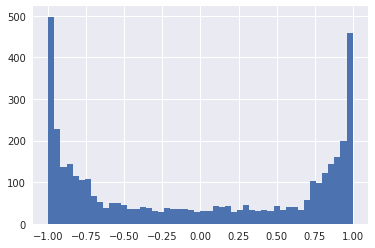

In [11]:
N = 4000
dist_phi = np.ones(N)*np.pi
open_escape_range = 3/2*np.pi
escape_range_mid = open_escape_range/2
phis = dist_phi + np.random.rand(N) * open_escape_range + np.pi - escape_range_mid
sins = np.sin(phis)
plt.hist(sins, bins=50)
plt.show()

In [12]:
np.arctan2(-0.01, -1)

-3.131592986903128

In [13]:
from scipy.signal import welch, spectrogram
import scipy.fftpack as sft

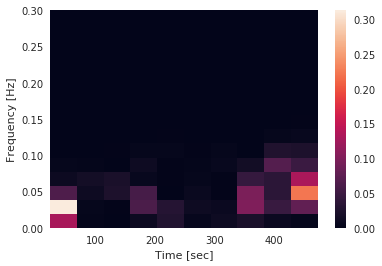

In [26]:
f, t, Sxx = spectrogram(dat, fs=20, nperseg=1024, window='hann')
plt.pcolormesh(t, f, Sxx)
plt.colorbar()
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim([0, 0.3])
plt.show()

In [15]:
tstart_idx = int(50/traj.par.output)
dat = stlkde.mean(std=50)
simdat = {'pol': pol[tstart_idx:], 'stlkde': dat[tstart_idx:], 'coh': coh[tstart_idx:]}
simdf = pd.DataFrame(simdat)
pol_ccoef_vals = []
coh_ccoef_vals = []
lags = np.arange(-800, 801, step=20)
for lag in lags:
    shifted_pol = np.roll(simdf['pol'], shift=lag)
    shifted_coh = np.roll(simdf['coh'], shift=lag)
    pol_ccoef_vals.append(np.corrcoef(shifted_pol, simdf['stlkde'])[0, 1])
    coh_ccoef_vals.append(np.corrcoef(shifted_coh, simdf['stlkde'])[0, 1])

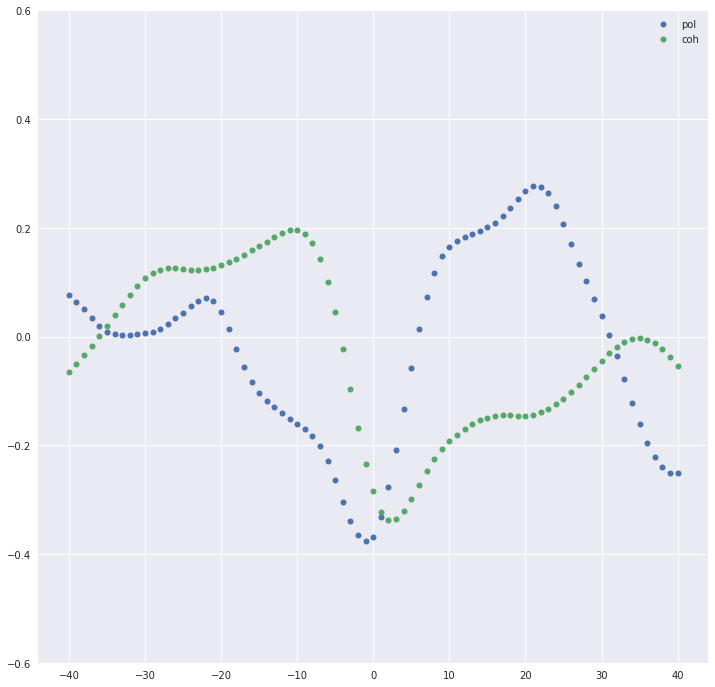

In [16]:
plt.figure(figsize=(12, 12))
plt.plot(lags*traj.par.output, pol_ccoef_vals, '.', ms=12, label='pol')
plt.plot(lags*traj.par.output, coh_ccoef_vals, '.', ms=12, label='coh')
plt.legend()
plt.ylim([-0.6, 0.6])
plt.show()

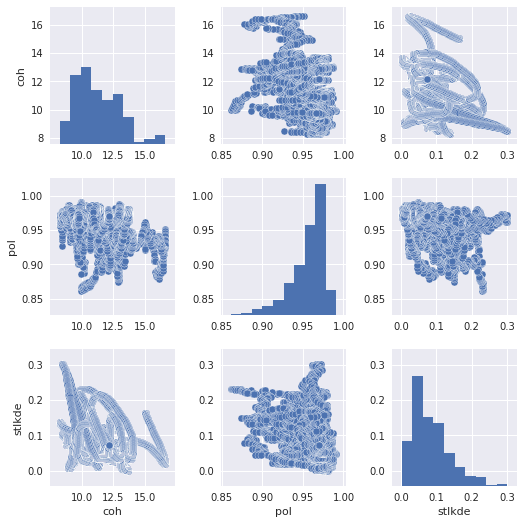

In [17]:
sns.pairplot(simdf)
plt.show()

In [18]:
startles.shape

(10001, 40)

In [22]:
plt.imshow(pol, aspect='auto')
plt.show()

TypeError: Invalid dimensions for image data

In [20]:
np.sum(startles)

885

In [21]:
pol.shape

(10001,)